In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from torch.autograd import Variable
from torch.utils.data import Dataset,DataLoader,TensorDataset
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset,DataLoader,TensorDataset
from sklearn.preprocessing import MinMaxScaler
from torch import nn
import seaborn as sns

In [2]:
dfi = pd.read_csv('./Data/Weather/london.csv')
dfi

DATE  WND_DEG  WND_SPEED[m/s]  VIS[m]  TMP[C]  DEW[C]  \
0       2024-01-01 00:00:00    240.0            6.70  9999.0     9.0     5.0   
1       2023-12-31 23:00:00    240.0            6.95  9999.0     9.0     5.0   
2       2023-12-31 22:00:00    240.0            7.95  9999.0     8.5     5.0   
3       2023-12-31 21:00:00    240.0            7.70  9999.0     9.0     4.5   
4       2023-12-31 20:00:00    240.0            6.70  9999.0     8.5     4.5   
...                     ...      ...             ...     ...     ...     ...   
235153  1988-01-29 17:00:00    270.0            6.45  8500.0     5.0     5.0   
235154  1988-01-29 16:00:00    280.0            6.95  7000.0     5.0     5.0   
235155  1988-01-29 15:00:00    300.0            9.00  7500.0     5.0     5.0   
235156  1988-01-29 14:00:00    300.0            5.90  7000.0     5.0     5.0   
235157  1988-01-29 13:00:00    300.0            5.70  7000.0     6.0     6.0   

        AP[hPa]  CIG[m]  
0         995.0   914.0  
1         994.5  1310.5  
2         993.5   990.5  
3         993.0   838.5  
4         992.0  1295.5  
...         ...     ...  
235153    974.9   285.0  
235154    973.9  1380.0  
235155    972.9   405.0  
235156    971.4   420.0  
235157    970.9   360.0  

[235158 rows x 8 columns]

In [3]:
df = dfi.loc[dfi['DATE'] > '2023-07-01']
df

DATE  WND_DEG  WND_SPEED[m/s]  VIS[m]  TMP[C]  DEW[C]  \
0     2024-01-01 00:00:00    240.0            6.70  9999.0     9.0     5.0   
1     2023-12-31 23:00:00    240.0            6.95  9999.0     9.0     5.0   
2     2023-12-31 22:00:00    240.0            7.95  9999.0     8.5     5.0   
3     2023-12-31 21:00:00    240.0            7.70  9999.0     9.0     4.5   
4     2023-12-31 20:00:00    240.0            6.70  9999.0     8.5     4.5   
...                   ...      ...             ...     ...     ...     ...   
4382  2023-07-01 04:00:00    265.0            4.85  7499.5    17.5    16.0   
4383  2023-07-01 03:00:00    260.0            5.40  9999.0    18.0    15.5   
4384  2023-07-01 02:00:00    250.0            4.85  9999.0    18.0    16.0   
4385  2023-07-01 01:00:00    235.0            5.40  9999.0    19.0    16.0   
4386  2023-07-01 00:00:00    240.0            5.15  9999.0    18.5    16.0   

      AP[hPa]  CIG[m]  
0       995.0   914.0  
1       994.5  1310.5  
2       993.5   990.5  
3       993.0   838.5  
4       992.0  1295.5  
...       ...     ...  
4382   1004.0   381.0  
4383   1004.0   427.0  
4384   1004.0   381.0  
4385   1005.0   381.0  
4386   1005.0   365.5  

[4387 rows x 8 columns]

In [4]:
df.rename(columns={'DATE': 'date', 'WND_DEG': 'wind_deg', 'WND_SPEED[m/s]': 'wind_sp', 'VIS[m]': 'vis'
, 'TMP[C]': 'temp', 'DEW[C]': 'dew', 'AP[hPa]':'press','CIG[m]':'ceil'}, inplace=True)
df = df[['date','wind_sp','dew','press','temp']]
df = df.set_index('date')
df = df.dropna()
#df = df.reset_index(drop=True)
df

/tmp/ipykernel_3688/198232581.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'DATE': 'date', 'WND_DEG': 'wind_deg', 'WND_SPEED[m/s]': 'wind_sp', 'VIS[m]': 'vis'


wind_sp   dew   press  temp
date                                            
2024-01-01 00:00:00     6.70   5.0   995.0   9.0
2023-12-31 23:00:00     6.95   5.0   994.5   9.0
2023-12-31 22:00:00     7.95   5.0   993.5   8.5
2023-12-31 21:00:00     7.70   4.5   993.0   9.0
2023-12-31 20:00:00     6.70   4.5   992.0   8.5
...                      ...   ...     ...   ...
2023-07-01 04:00:00     4.85  16.0  1004.0  17.5
2023-07-01 03:00:00     5.40  15.5  1004.0  18.0
2023-07-01 02:00:00     4.85  16.0  1004.0  18.0
2023-07-01 01:00:00     5.40  16.0  1005.0  19.0
2023-07-01 00:00:00     5.15  16.0  1005.0  18.5

[4387 rows x 4 columns]

# **STATISTICAL TESTS**

<Axes: xlabel='date'>

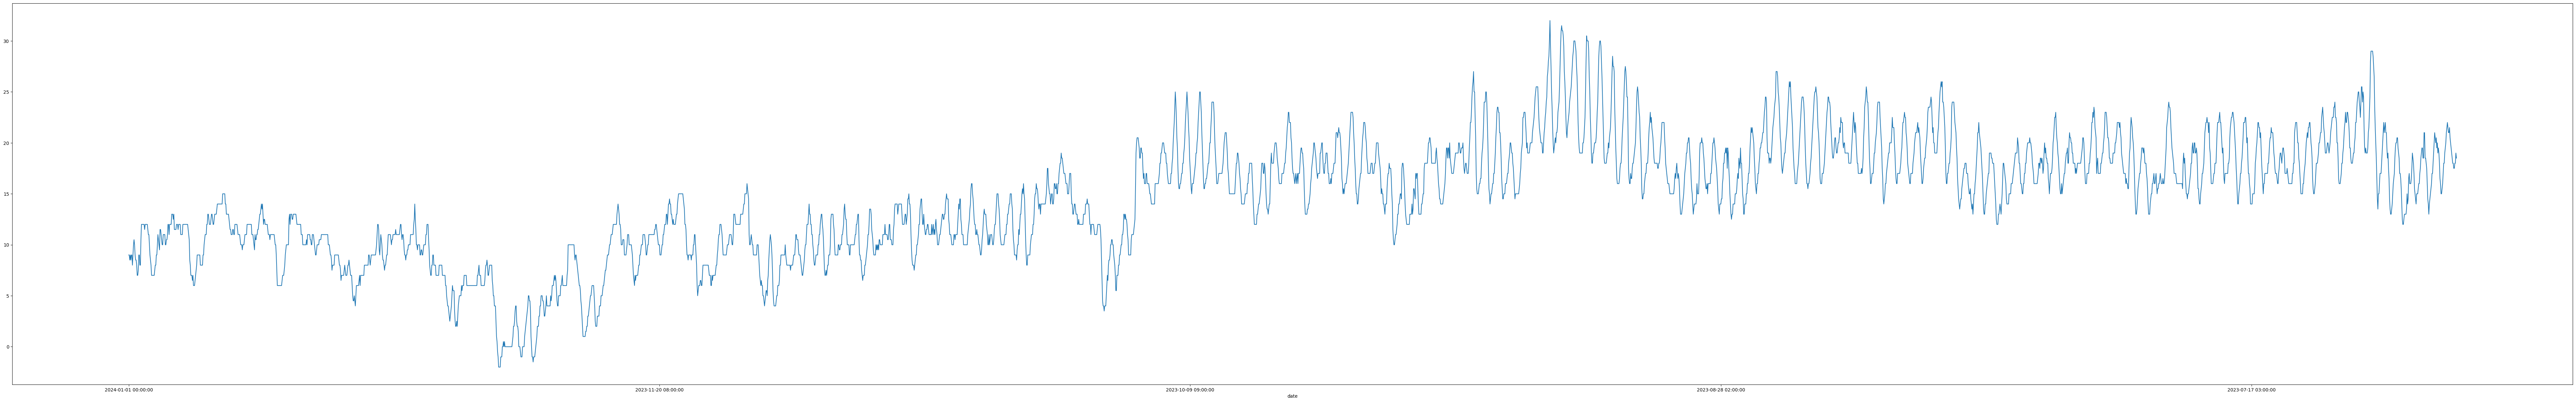

In [5]:
from pylab import rcParams
rcParams['figure.figsize'] = 100, 15
df['temp'].plot()

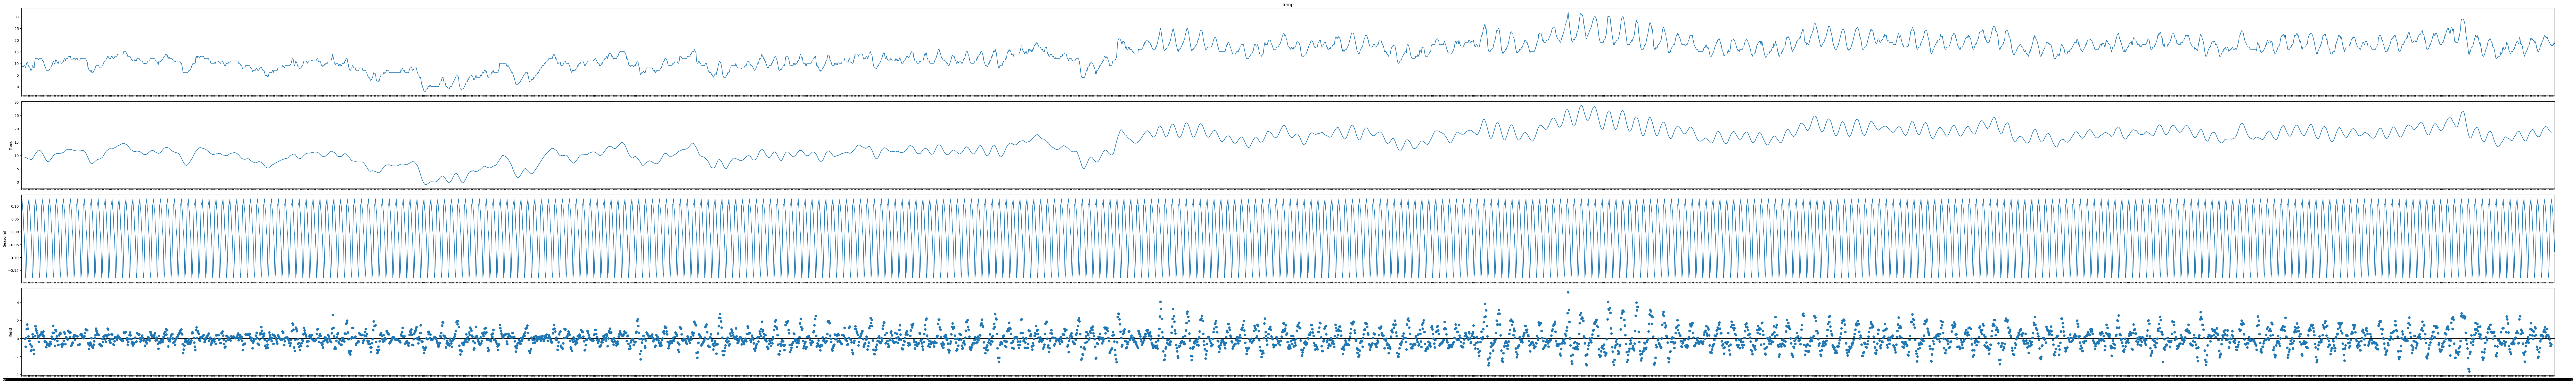

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df['temp'], model='additive', period=12) 
result.plot()
plt.show()

In [7]:
from statsmodels.tsa.stattools import adfuller

def adf_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")

In [8]:
adf_test(df['temp'])

ADF Test Statistic : -3.108165106841873
p-value : 0.025954805368116847
#Lags Used : 25
Number of Observations : 4361
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


<Figure size 1200x600 with 0 Axes>

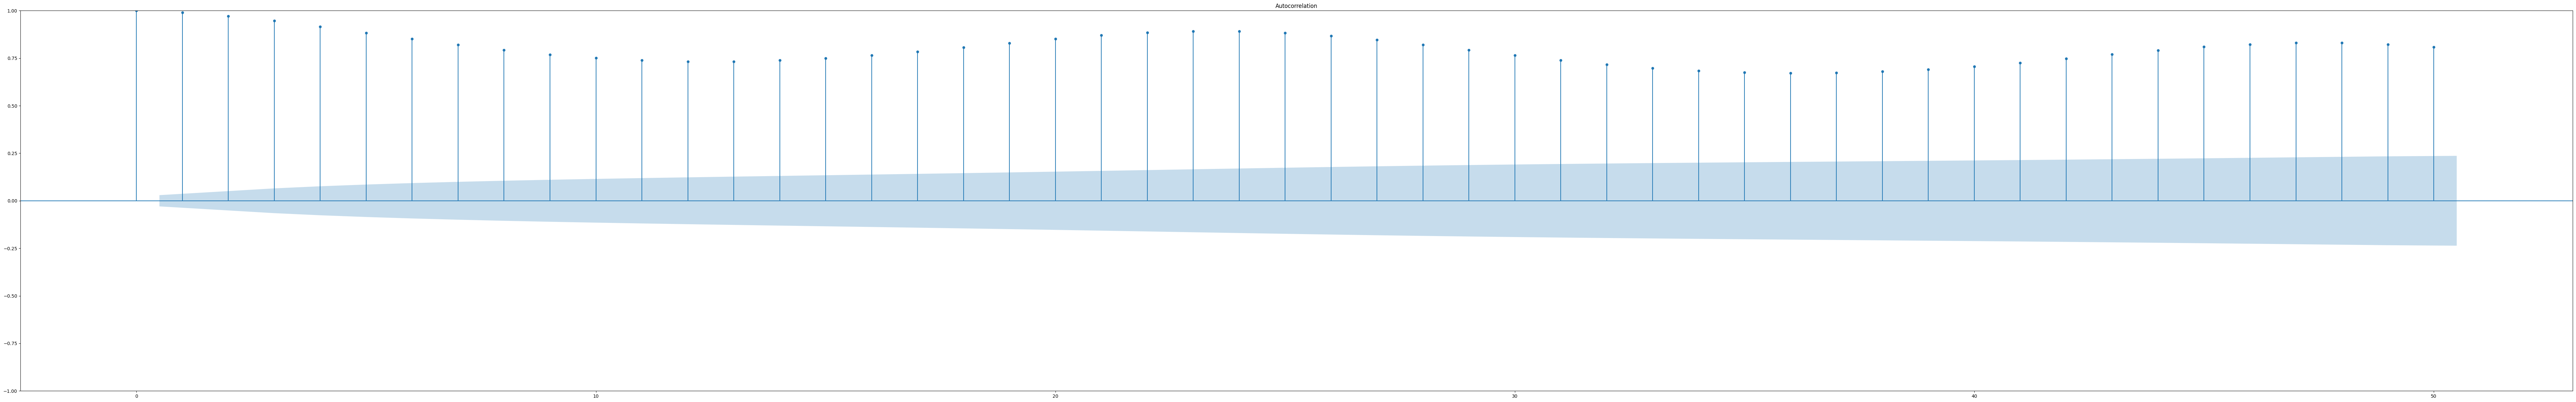

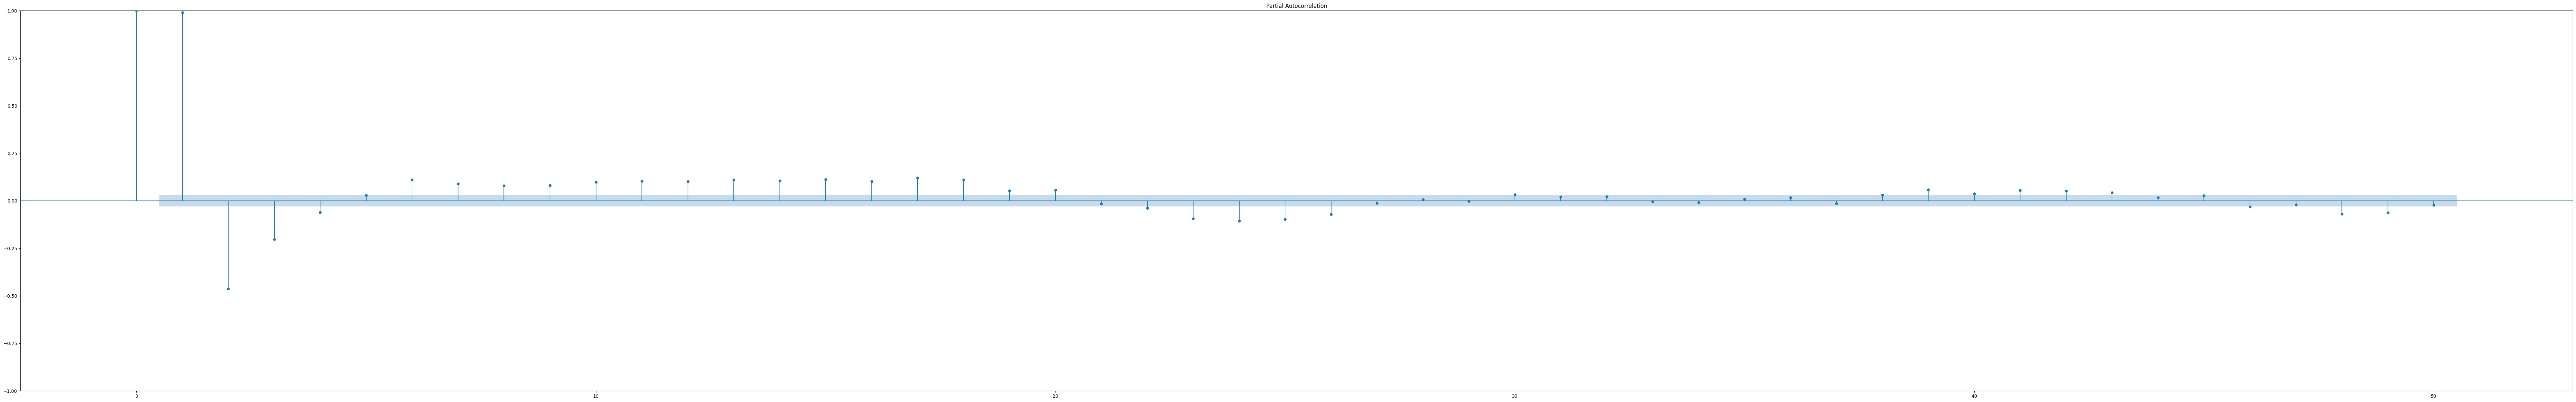

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))
plot_acf(df['temp'], lags=50) # p = 
plot_pacf(df['temp'], lags=50) # q = 
plt.show()

# **ARIMA MODEL**

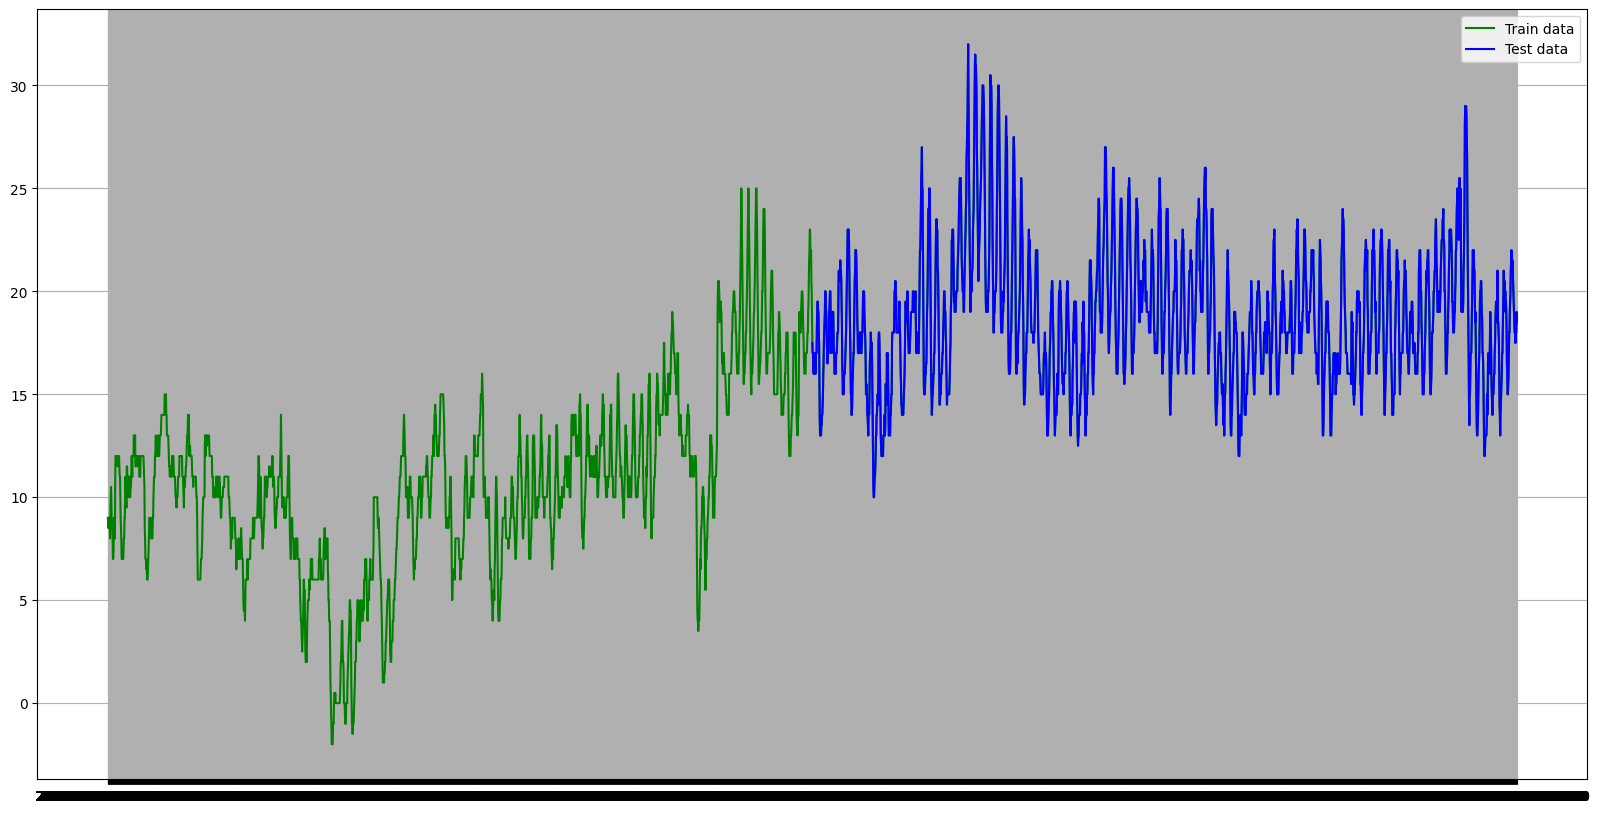

In [10]:
train_data, test_data = df[:int(len(df)*0.5)], df[int(len(df)*0.5):]
plt.figure(figsize=(20,10))
plt.grid(True)
plt.plot(df['temp'], 'green', label='Train data')
plt.plot(test_data['temp'], 'blue', label='Test data')
plt.legend()

In [11]:
'''import itertools
import warnings
warnings.filterwarnings("ignore")
q_arima = range(0, 10)
d_arima = range(0,1)
p_arima = range(0, 27)
AIC_arima = []
ARIMAX_model = []
pdqs = [(x[0], x[1], x[2]) for x in list(itertools.product(p_arima, d_arima, q_arima))]

for pdq in pdqs:
    try:
        mod = ARIMA(train_data['temp'],order=pdq)

        results = mod.fit()
        print('ARIMAX{} - AIC:{}'.format(pdq, results.aic), end='\r')
        AIC_arima.append(results.aic)
        ARIMAX_model.append([(1,1,0), pdq])
    except:
            continue
    
print('The smallest AIC is {} for model ARIMAX{}'.format(min(AIC_arima),ARIMAX_model[AIC_arima.index(min(AIC_arima))][1]))
order_a = ARIMAX_model[AIC_arima.index(min(AIC_arima))][1]'''

'import itertools\nimport warnings\nwarnings.filterwarnings("ignore")\nq_arima = range(0, 10)\nd_arima = range(0,1)\np_arima = range(0, 27)\nAIC_arima = []\nARIMAX_model = []\npdqs = [(x[0], x[1], x[2]) for x in list(itertools.product(p_arima, d_arima, q_arima))]\n\nfor pdq in pdqs:\n    try:\n        mod = ARIMA(train_data[\'temp\'],order=pdq)\n\n        results = mod.fit()\n        print(\'ARIMAX{} - AIC:{}\'.format(pdq, results.aic), end=\'\r\')\n        AIC_arima.append(results.aic)\n        ARIMAX_model.append([(1,1,0), pdq])\n    except:\n            continue\n    \nprint(\'The smallest AIC is {} for model ARIMAX{}\'.format(min(AIC_arima),ARIMAX_model[AIC_arima.index(min(AIC_arima))][1]))\norder_a = ARIMAX_model[AIC_arima.index(min(AIC_arima))][1]'

In [12]:
order_a = (25, 0, 6)

In [13]:
train, test = train_data['temp'], test_data['temp']

model = ARIMA(train, order=order_a)
result = model.fit()

forecast_a = result.get_forecast(steps=len(test))
predicted_mean = forecast_a.predicted_mean

mse = mean_squared_error(test, predicted_mean)
rmse = math.sqrt(mse)
print(f'Mean Squared Error: {mse}')

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be i

Mean Squared Error: 19.57988095473531


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [14]:
print(mse)
print(rmse)

19.57988095473531
4.424915926290048


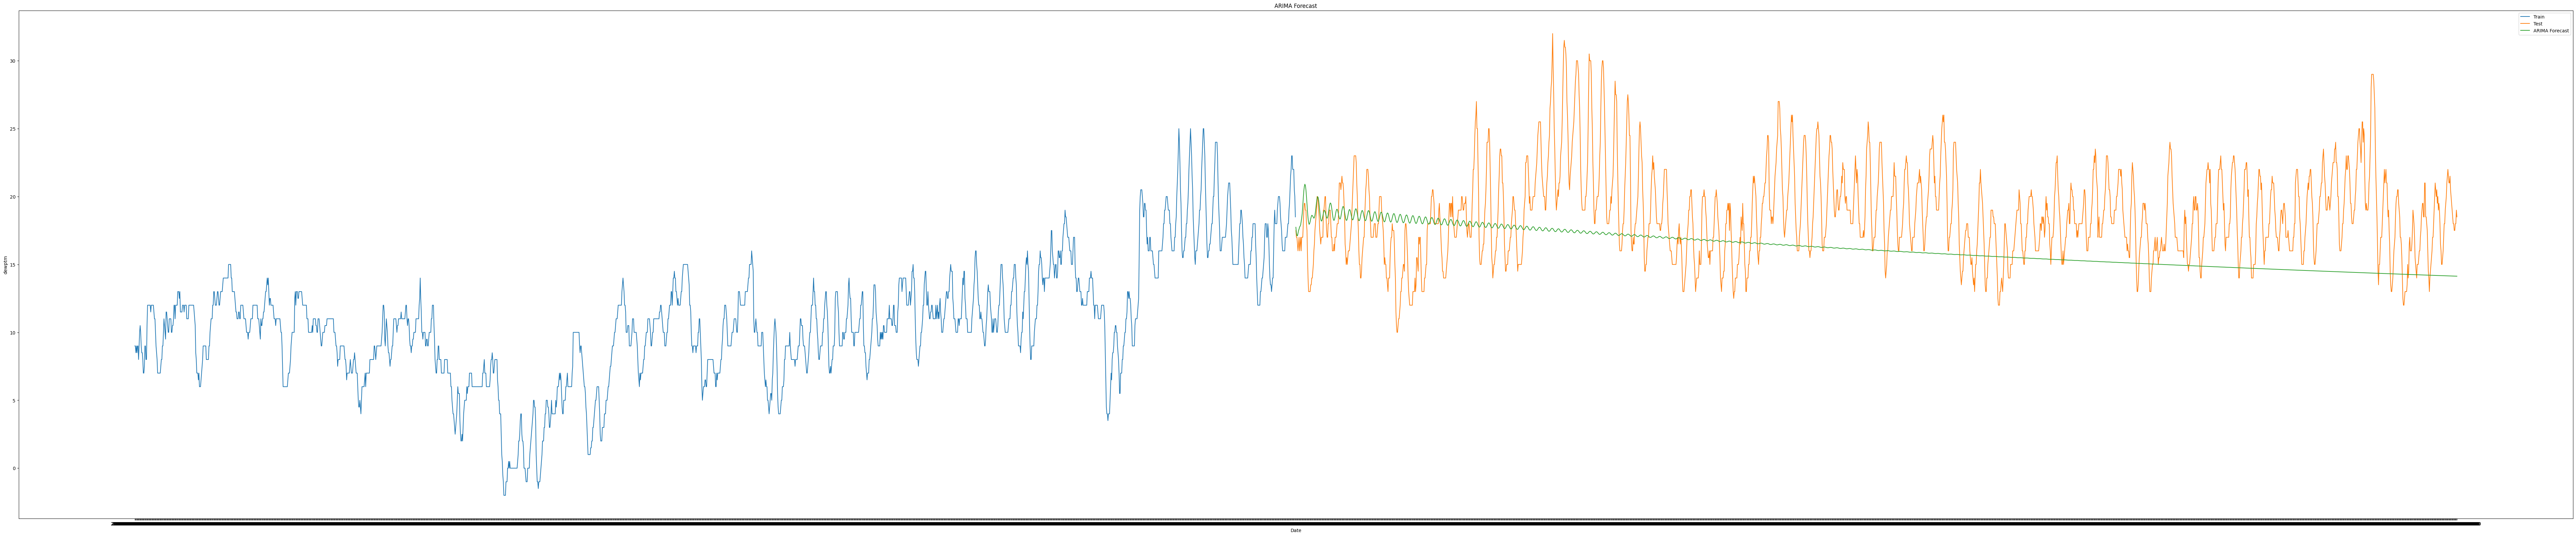

In [15]:
plt.figure(figsize=(100, 20))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, predicted_mean, label='ARIMA Forecast')
# plt.fill_between(forecast.conf_int().index,
#                  forecast.conf_int().iloc[:, 0],
#                  forecast.conf_int().iloc[:, 1], color='k', alpha=0.2)
plt.xlabel('Date')
plt.ylabel('dewptm')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()

# **QLSTM MODEL**

In [16]:
ARIMA_Result =  pd.DataFrame(columns=['raw', 'predicted','residuals'])
ARIMA_Result['raw'] = test_data['temp'].copy()
ARIMA_Result['predicted'] = predicted_mean.to_numpy()
ARIMA_Result['residuals'] = ARIMA_Result['raw'] - ARIMA_Result['predicted']
std_residuals = ARIMA_Result['residuals'].std()
ARIMA_Result['std_residuals'] = ARIMA_Result['residuals'] / std_residuals
ARIMA_Result['nxt_target'] = ARIMA_Result['residuals'].shift(-1)
ARIMA_Result['nxt_target'][len(ARIMA_Result)-1] = ARIMA_Result['nxt_target'][len(ARIMA_Result)-2]
ARIMA_Result

/tmp/ipykernel_3688/1814787340.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ARIMA_Result['nxt_target'][len(ARIMA_Result)-1] = ARIMA_Result['nxt_target'][len(ARIMA_Result)-2]
/tmp/ipykernel_3688/1814787340.py:8: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ARIMA_Result['nxt_target'][len(ARIMA_Result)-1] = ARIMA_Result['nxt_target'][len(ARIMA_Result)-2]


raw  predicted  residuals  std_residuals  nxt_target
date                                                                      
2023-10-01 07:00:00  17.5  17.741165  -0.241165      -0.066206   -0.307480
2023-10-01 06:00:00  17.0  17.307480  -0.307480      -0.084411   -0.119682
2023-10-01 05:00:00  17.0  17.119682  -0.119682      -0.032856   -0.609991
2023-10-01 04:00:00  16.5  17.109991  -0.609991      -0.167458   -1.289718
2023-10-01 03:00:00  16.0  17.289718  -1.289718      -0.354060   -0.998922
...                   ...        ...        ...            ...         ...
2023-07-01 04:00:00  17.5  14.140376   3.359624       0.922303    3.860897
2023-07-01 03:00:00  18.0  14.139103   3.860897       1.059915    3.862102
2023-07-01 02:00:00  18.0  14.137898   3.862102       1.060245    4.863290
2023-07-01 01:00:00  19.0  14.136710   4.863290       1.335097    4.364514
2023-07-01 00:00:00  18.5  14.135486   4.364514       1.198170    4.364514

[2194 rows x 5 columns]

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import Parameter
import torch.utils.data as Data
from torch.utils.data import RandomSampler
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
import pennylane as qml
import pytorch_lightning as pl
import math
import time

In [18]:
def data_process(data, window_size, predict_size):
    scaler1 = StandardScaler()
    scaler2 = StandardScaler()
    d_y = scaler1.fit_transform(data.iloc[:,-1:]) 
    data = scaler2.fit_transform(data.iloc[:,:1])

    data_in = []
    data_out = []
    # range(window_size,len(data)-predict_size+1) range(data.shape[0] - window_size - predict_size + 1)
    for i in range(window_size,len(data)-predict_size+1):
        data_in.append(data[i-window_size:i,0:data.shape[0]])
        data_out.append(d_y[i + predict_size - 1:i + predict_size,0])

    data_in = np.array(data_in)
    data_out = np.array(data_out)

    data_process = {'datain': data_in, 'dataout': data_out}

    return data_process, scaler1 , scaler2

In [19]:
from numpy.random import default_rng
from qiskit_algorithms.utils import algorithm_globals
qubits = 2
seed = 42
np.random.seed(seed)
torch.manual_seed(42)
rng = default_rng(seed)
algorithm_globals.random_seed = seed
features_size = 1
#window_size = features_size * 3
window_size = 10
predict_size = 1

In [20]:
size = int(len(ARIMA_Result) * 0.5)

train = ARIMA_Result[['residuals','nxt_target']][:size].copy()
test = ARIMA_Result[['residuals','nxt_target']][size:].copy()

In [21]:
train_processed, train_target_scalar, train_scaler = data_process(train, window_size, predict_size)
X_train, y_train = train_processed['datain'], train_processed['dataout']

test_processed, test_target_scalar, test_scaler = data_process(test, window_size, predict_size)
X_test, y_test = test_processed['datain'], test_processed['dataout']

In [22]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))

y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

In [23]:
class QLSTM(nn.Module):
    def __init__(self,
                input_size,
                hidden_size,
                n_qubits=4,
                n_qlayers=1,
                batch_first=True,
                return_sequences=False,
                return_state=False,
                backend="default.qubit"):
        super(QLSTM, self).__init__()
        self.n_inputs = input_size
        self.hidden_size = hidden_size
        self.concat_size = self.n_inputs + self.hidden_size
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        self.backend = backend  # "default.qubit", "qiskit.basicaer", "qiskit.ibm"

        self.batch_first = batch_first
        self.return_sequences = return_sequences
        self.return_state = return_state

        #self.dev = qml.device("default.qubit", wires=self.n_qubits)
        #self.dev = qml.device('qiskit.basicaer', wires=self.n_qubits)
        #self.dev = qml.device('qiskit.ibm', wires=self.n_qubits)
        # use 'qiskit.ibmq' instead to run on hardware

        self.wires_forget = [f"wire_forget_{i}" for i in range(self.n_qubits)]
        self.wires_input = [f"wire_input_{i}" for i in range(self.n_qubits)]
        self.wires_update = [f"wire_update_{i}" for i in range(self.n_qubits)]
        self.wires_output = [f"wire_output_{i}" for i in range(self.n_qubits)]

        self.dev_forget = qml.device(self.backend, wires=self.wires_forget)
        self.dev_input = qml.device(self.backend, wires=self.wires_input)
        self.dev_update = qml.device(self.backend, wires=self.wires_update)
        self.dev_output = qml.device(self.backend, wires=self.wires_output)

        def _circuit_forget(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_forget)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_forget)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_forget]
        self.qlayer_forget = qml.QNode(_circuit_forget, self.dev_forget, interface="torch")

        def _circuit_input(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_input)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_input)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_input]
        self.qlayer_input = qml.QNode(_circuit_input, self.dev_input, interface="torch")

        def _circuit_update(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_update)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_update)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_update]
        self.qlayer_update = qml.QNode(_circuit_update, self.dev_update, interface="torch")

        def _circuit_output(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_output)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_output)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_output]
        self.qlayer_output = qml.QNode(_circuit_output, self.dev_output, interface="torch")

        weight_shapes = {"weights": (n_qlayers, n_qubits)}
        print(f"weight_shapes = (n_qlayers, n_qubits) = ({n_qlayers}, {n_qubits})")

        self.clayer_in = torch.nn.Linear(self.concat_size, n_qubits)
        self.VQC = {
            'forget': qml.qnn.TorchLayer(self.qlayer_forget, weight_shapes),
            'input': qml.qnn.TorchLayer(self.qlayer_input, weight_shapes),
            'update': qml.qnn.TorchLayer(self.qlayer_update, weight_shapes),
            'output': qml.qnn.TorchLayer(self.qlayer_output, weight_shapes)
        }
        self.clayer_out = torch.nn.Linear(self.n_qubits, self.hidden_size)
        #self.clayer_out = [torch.nn.Linear(n_qubits, self.hidden_size) for _ in range(4)]

    def forward(self, x, init_states=None):
        '''
        x.shape is (batch_size, seq_length, feature_size)
        recurrent_activation -> sigmoid
        activation -> tanh
        '''
        if self.batch_first is True:
            batch_size, seq_length, features_size = x.size()
        else:
            seq_length, batch_size, features_size = x.size()

        hidden_seq = []
        if init_states is None:
            h_t = torch.zeros(batch_size, self.hidden_size)  # hidden state (output)
            c_t = torch.zeros(batch_size, self.hidden_size)  # cell state
        else:
            # for now we ignore the fact that in PyTorch you can stack multiple RNNs
            # so we take only the first elements of the init_states tuple init_states[0][0], init_states[1][0]
            h_t, c_t = init_states
            h_t = h_t[0]
            c_t = c_t[0]

        for t in range(seq_length):
            # get features from the t-th element in seq, for all entries in the batch
            x_t = x[:, t, :]

            # Concatenate input and hidden state
            v_t = torch.cat((h_t, x_t), dim=1)

            # match qubit dimension
            y_t = self.clayer_in(v_t)

            f_t = torch.sigmoid(self.clayer_out(self.VQC['forget'](y_t)))  # forget block
            i_t = torch.sigmoid(self.clayer_out(self.VQC['input'](y_t)))  # input block
            g_t = torch.tanh(self.clayer_out(self.VQC['update'](y_t)))  # update block
            o_t = torch.sigmoid(self.clayer_out(self.VQC['output'](y_t))) # output block

            c_t = (f_t * c_t) + (i_t * g_t)
            h_t = o_t * torch.tanh(c_t)

            hidden_seq.append(h_t.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return hidden_seq, (h_t, c_t)

class QRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units, n_qubits=0, n_qlayers=1):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = QLSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            n_qubits = n_qubits,
            n_qlayers= n_qlayers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [24]:
batch_size = 4
learning_rate = 0.004
num_epochs = 5
trainDataloader = DataLoader(TensorDataset(X_train, y_train), batch_size = batch_size, shuffle = False)
testDataloader = DataLoader(TensorDataset(X_test,y_test), batch_size = batch_size, shuffle = False)
device = "cpu"
modelQ = QRegressionLSTM(num_sensors=1, hidden_units= 6, n_qubits=1)
criterion = nn.MSELoss()
optimizerQ = torch.optim.Adam(modelQ.parameters(), lr = learning_rate, betas = (0.0, 0.9))

weight_shapes = (n_qlayers, n_qubits) = (1, 1)


In [25]:
histQ = np.zeros(num_epochs)
histQacc = np.zeros(num_epochs)

count = 0
for epoch in range(num_epochs):
    loss_Q = []
    rmse_q = []
    correct = 0
    batches = 0
    for (x, y) in trainDataloader:
        modelQ.zero_grad()
        x = x.to(device)
        y = y.to(device)
        output = modelQ(x)

        label = y.squeeze(1)
        #print(output)
        #print(label)
        lossQ = criterion(output, label)
        lossQ.backward()
        optimizerQ.step()
        
        #correct += (output == label).float().sum()
        #batches +=1
        
        loss_Q.append(lossQ.item())
    histQ[epoch] = np.sum(loss_Q)
    
    #print(correct)
    #histQacc[epoch] = correct/batches
    print(f'[{epoch+1}/{num_epochs}]  LossQ:{np.sum(loss_Q)}')

[1/5]  LossQ:231.9907427172875
[2/5]  LossQ:140.75733583117835
[3/5]  LossQ:74.50722723815124
[4/5]  LossQ:53.61260375124402
[5/5]  LossQ:45.843664605898084


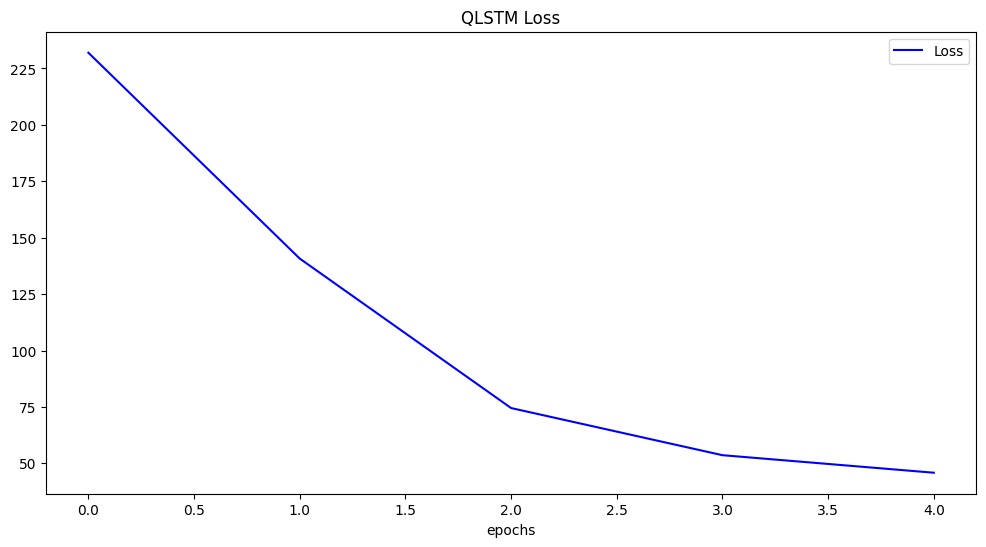

In [26]:
np.savetxt('./SavedModels/Weather/London/loss/arima_qlstm.txt',histQ)
plt.figure(figsize = (12, 6))
plt.plot(histQ, color = 'blue', label = 'Loss')
plt.title('QLSTM Loss')
plt.xlabel('epochs')
plt.legend(loc = 'upper right')

In [27]:
histQ1 = histQ 

In [28]:
def predict(data_loader, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)


    return output

In [29]:
pred_y_train = modelQ(X_train)
pred_y_test = modelQ(X_test)

print(pred_y_train)

tensor([-0.5432, -0.6164, -0.6104,  ..., -0.0317, -0.0500,  0.2036],
       grad_fn=<ViewBackward0>)


In [30]:
pred_y_train = pred_y_train.reshape(-1, 1)
pred_y_test = pred_y_test.reshape(-1, 1)
pred_y_train

tensor([[-0.5432],
        [-0.6164],
        [-0.6104],
        ...,
        [-0.0317],
        [-0.0500],
        [ 0.2036]], grad_fn=<ViewBackward0>)

In [31]:
y_train_true = train_target_scalar.inverse_transform(y_train)
y_train_pred = train_target_scalar.inverse_transform(pred_y_train.cpu().detach().numpy())
y_test_true = test_target_scalar.inverse_transform(y_test)
y_test_pred = test_target_scalar.inverse_transform(pred_y_test.cpu().detach().numpy())

In [32]:
np.savetxt('./SavedModels/Weather/London/train/arima_qlstm.txt',y_train_pred)
np.savetxt('./SavedModels/Weather/London/test/arima_qlstm.txt',y_test_pred)

Training dataset MSE: 2.8762977128562404 RMSE:1.6959651272523975


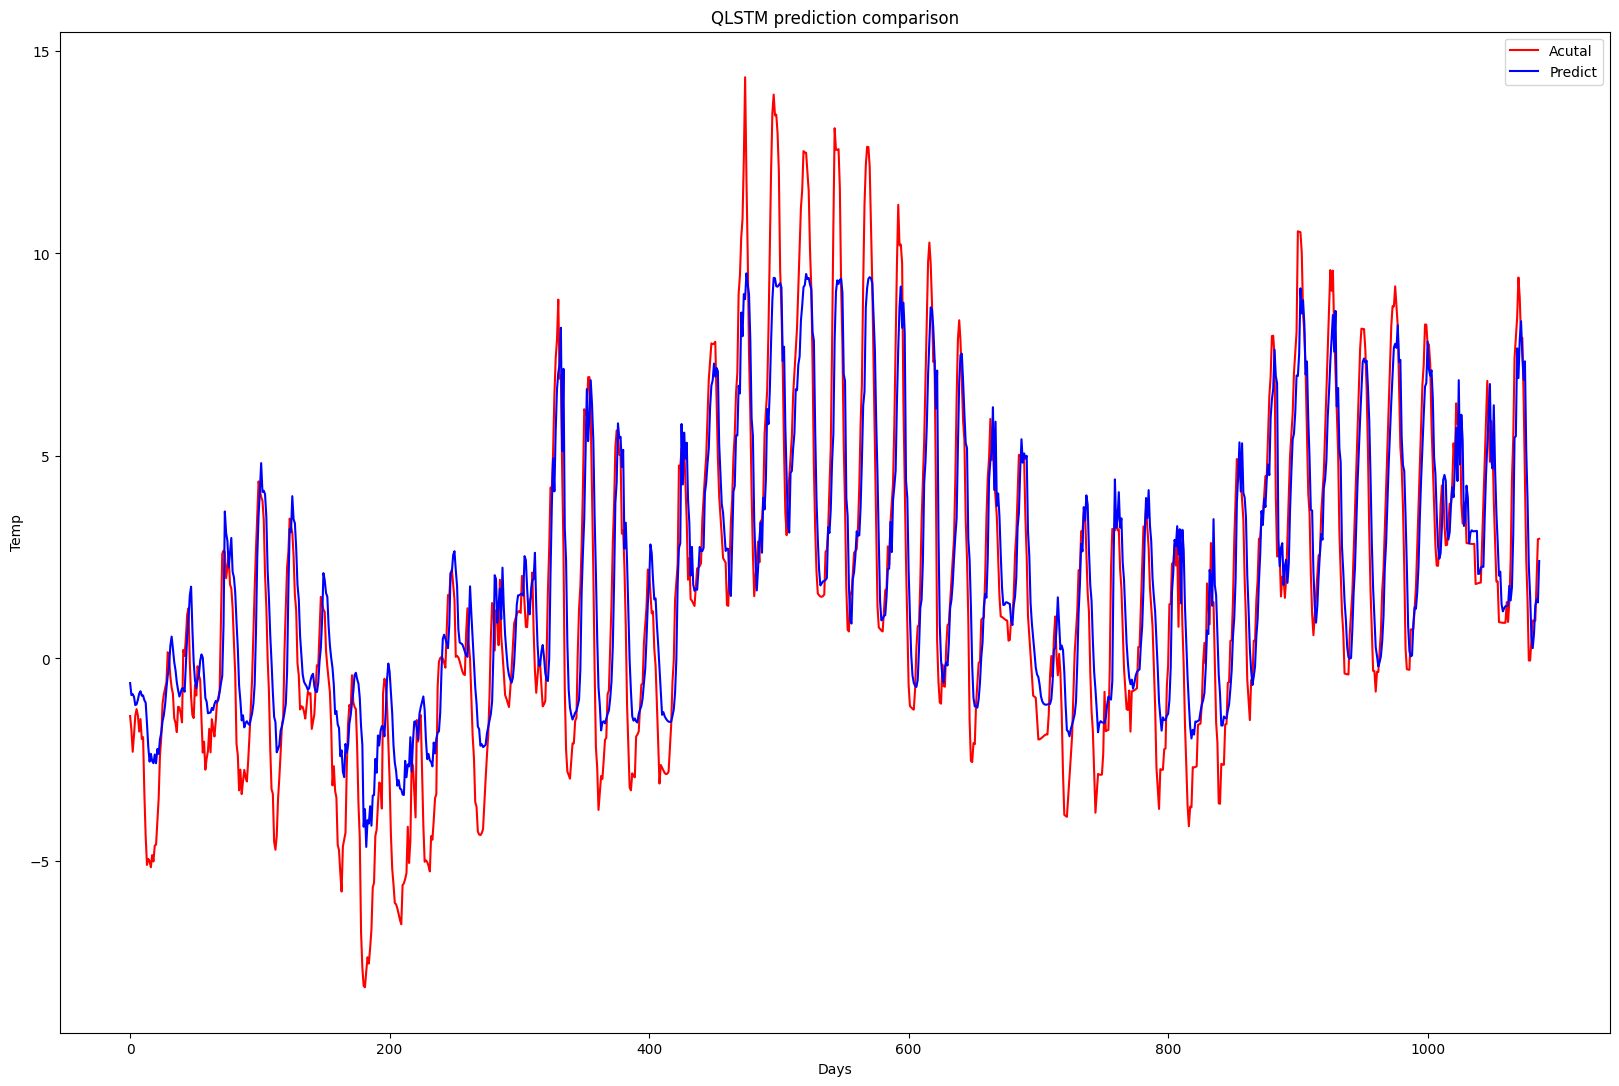

In [33]:
plt.figure(figsize=(20, 13))
plt.plot(y_train_true, color = 'red', label = 'Acutal')
plt.plot(y_train_pred, color = 'blue', label = 'Predict')
plt.title('QLSTM prediction comparison')
plt.ylabel('Temp')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset MSE: {MSE} RMSE:{RMSE}')

Training dataset MSE:2.7871419384523226 RMSE:1.6694735512886458


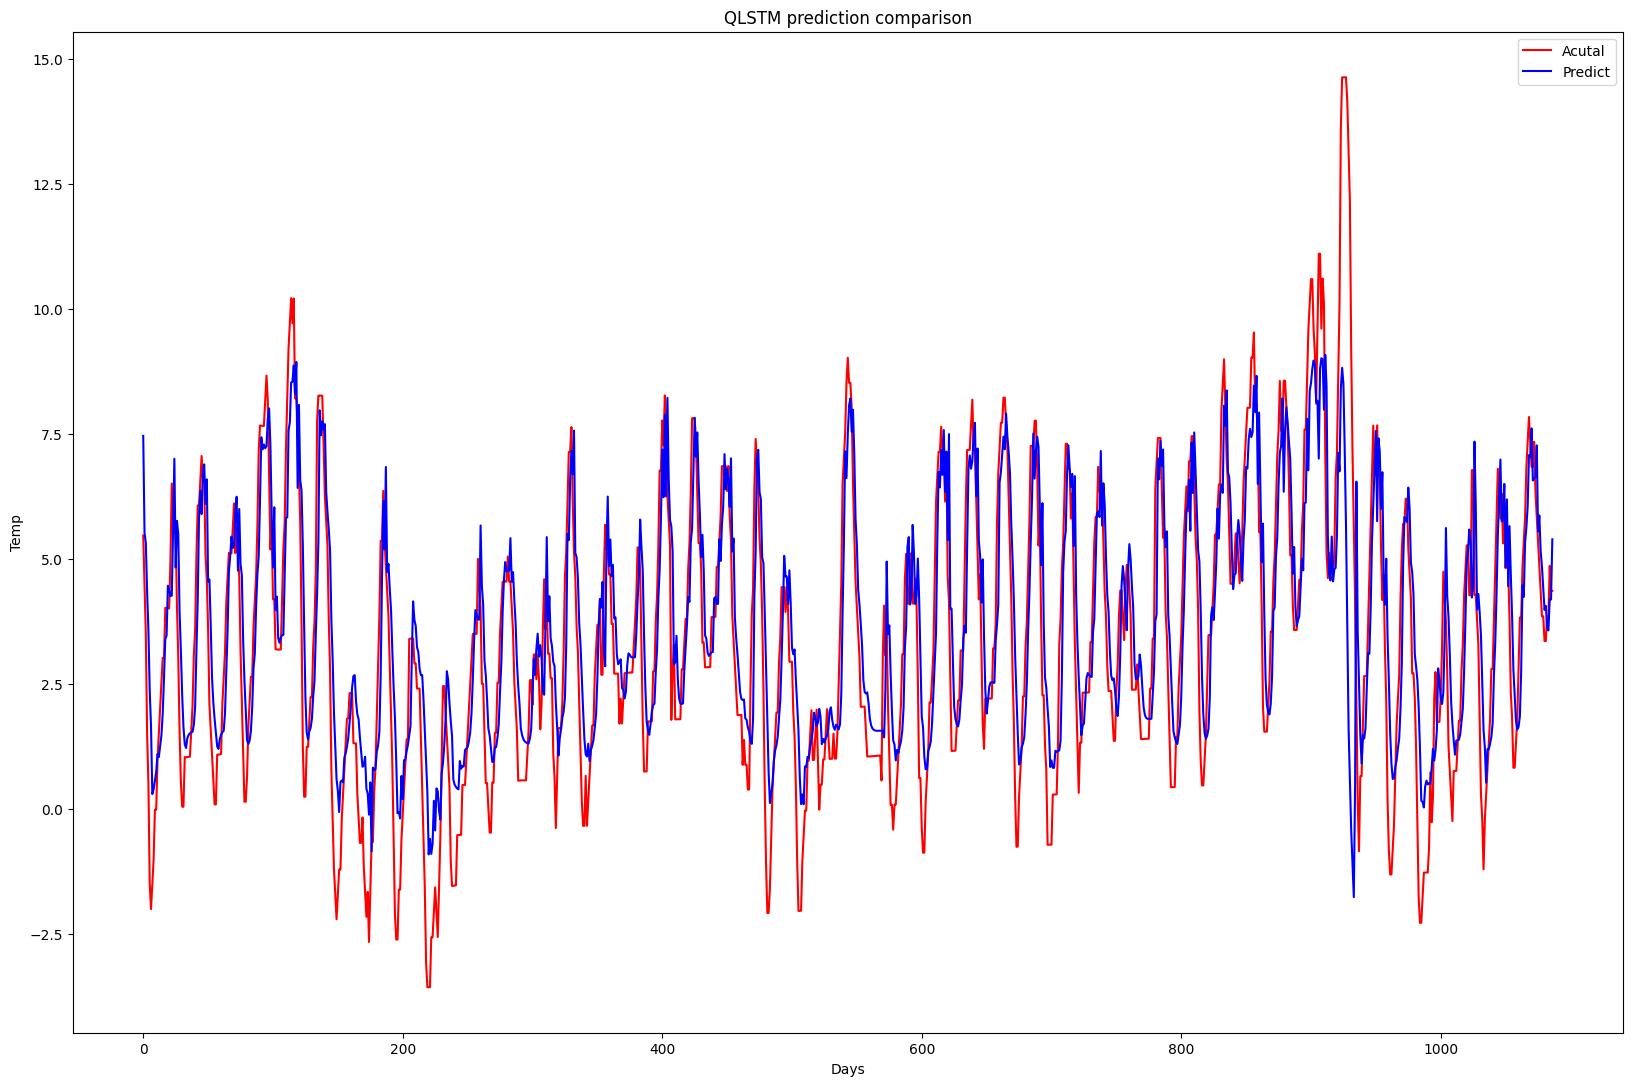

In [34]:
plt.figure(figsize=(20, 13))
plt.plot(y_test_true, color = 'red', label = 'Acutal')
plt.plot(y_test_pred, color = 'blue', label = 'Predict')
plt.title('QLSTM prediction comparison')
plt.ylabel('Temp')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset MSE:{MSE} RMSE:{RMSE}')

In [35]:
final_result_qlstm = ARIMA_Result['predicted'][size+window_size:].values + y_test_pred.squeeze(1)

In [36]:
frq = ARIMA_Result[['predicted','raw']][size+window_size:].copy()
frq['final'] = final_result_qlstm
frq

predicted   raw      final
date                                           
2023-08-15 12:00:00  16.037491  22.5  23.502289
2023-08-15 11:00:00  16.029912  21.5  21.549736
2023-08-15 10:00:00  16.020415  20.5  21.340542
2023-08-15 09:00:00  16.010989  19.5  20.351851
2023-08-15 08:00:00  16.003590  17.5  19.564568
...                        ...   ...        ...
2023-07-01 04:00:00  14.140376  17.5  17.752407
2023-07-01 03:00:00  14.139103  18.0  17.710707
2023-07-01 02:00:00  14.137898  18.0  18.340106
2023-07-01 01:00:00  14.136710  19.0  18.329629
2023-07-01 00:00:00  14.135486  18.5  19.529979

[1087 rows x 3 columns]

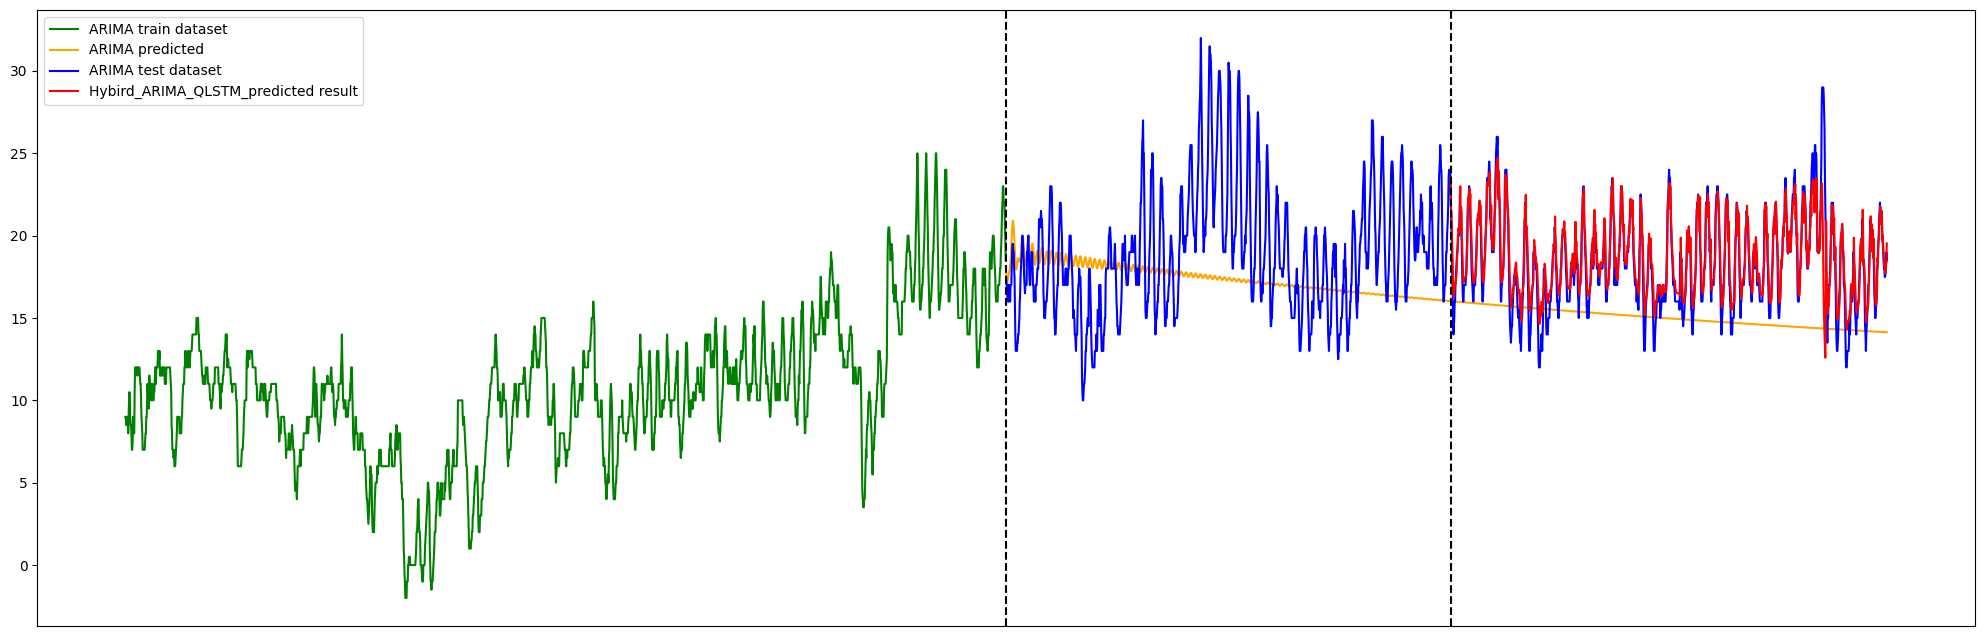

In [37]:
plt.figure(figsize=(25,8))
plt.plot(train_data['temp'], label ='ARIMA train dataset', color='green')
plt.plot(ARIMA_Result['predicted'], label ='ARIMA predicted', color='orange')
plt.plot(ARIMA_Result['raw'], label = "ARIMA test dataset", color ='blue')
plt.plot(frq['final'], label = 'Hybird_ARIMA_QLSTM_predicted result', color='red')
plt.axvline(x=len(train_data['temp']), c='black', linestyle='--')
plt.axvline(x=len(train_data['temp']) + len(ARIMA_Result['predicted']) - len(frq['final']), c='black', linestyle='--')
plt.gca().set_xticks([])
plt.plot()
plt.legend()
plt.show()

In [38]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

mse = mean_squared_error(final_result_qlstm,ARIMA_Result['raw'][size+window_size:].values )    
mae = mean_absolute_error(final_result_qlstm, ARIMA_Result['raw'][size+window_size:].values)
rmse = np.sqrt(mse)

print(f'X_test MSE: {mse}')
print(f'X_test MAE: {mae}')
print(f'X_test RMSE: {rmse}')

X_test MSE: 2.002004398415599
X_test MAE: 0.897805447509829
X_test RMSE: 1.4149220467628594


In [39]:
torch.save(modelQ.state_dict(),'./SavedModels/Weather/London/model/arima_QLSTM_sd')

# **LSTM MODEL**

In [40]:
class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [41]:
batch_size = 4
learning_rate = 0.004
num_epochs = 5
trainDataloader = DataLoader(TensorDataset(X_train, y_train), batch_size = batch_size, shuffle = False)
testDataloader = DataLoader(TensorDataset(X_test,y_test), batch_size = batch_size, shuffle = False)
device = "cpu"
modelQ = ShallowRegressionLSTM(num_sensors=1, hidden_units=6)
criterion = nn.MSELoss()
optimizerQ = torch.optim.Adam(modelQ.parameters(), lr = learning_rate, betas = (0.0, 0.9))

In [42]:
histQ = np.zeros(num_epochs)
histQacc = np.zeros(num_epochs)

count = 0
for epoch in range(num_epochs):
    loss_Q = []
    rmse_q = []
    correct = 0
    batches = 0
    for (x, y) in trainDataloader:
        modelQ.zero_grad()
        x = x.to(device)
        y = y.to(device)
        output = modelQ(x)

        label = y.squeeze(1)
        #print(output)
        #print(label)
        lossQ = criterion(output, label)
        lossQ.backward()
        optimizerQ.step()
        
        #correct += (output == label).float().sum()
        #batches +=1
        
        loss_Q.append(lossQ.item())
    histQ[epoch] = np.sum(loss_Q)
    
    #print(correct)
    #histQacc[epoch] = correct/batches
    print(f'[{epoch+1}/{num_epochs}]  LossQ:{np.sum(loss_Q)} ')

[1/5]  LossQ:136.01916293334216 
[2/5]  LossQ:46.93512305209879 
[3/5]  LossQ:27.963272043969482 
[4/5]  LossQ:21.868493732181378 
[5/5]  LossQ:20.49442402506247 


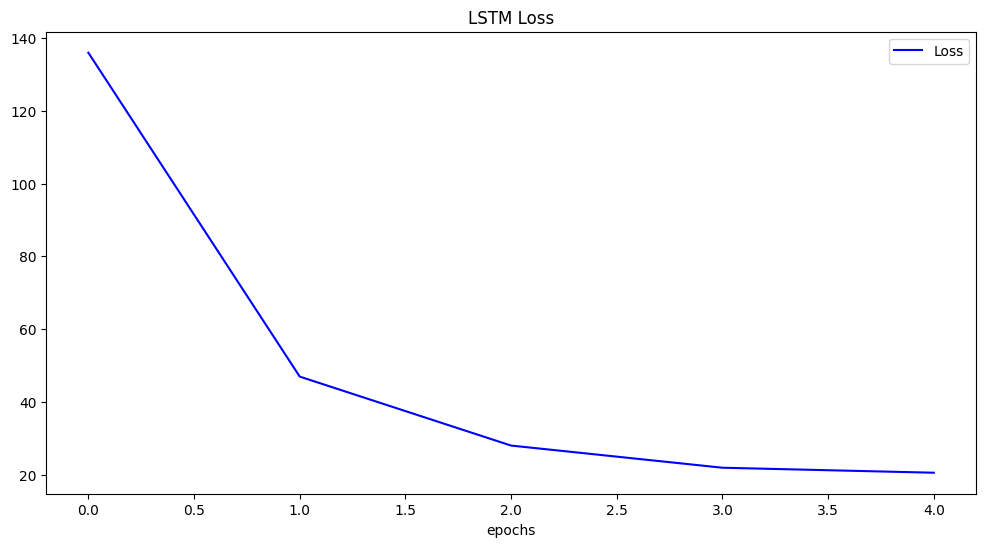

In [43]:
np.savetxt('./SavedModels/Weather/London/loss/arima_lstm.txt',histQ)
plt.figure(figsize = (12, 6))
plt.plot(histQ, color = 'blue', label = 'Loss')
plt.title('LSTM Loss')
plt.xlabel('epochs')
plt.legend(loc = 'upper right')

In [44]:
pred_y_train = modelQ(X_train)
pred_y_test = modelQ(X_test)
pred_y_train = pred_y_train.reshape(-1, 1)
pred_y_test = pred_y_test.reshape(-1, 1)

In [45]:
y_train_true = train_target_scalar.inverse_transform(y_train)
y_train_pred = train_target_scalar.inverse_transform(pred_y_train.cpu().detach().numpy())
y_test_true = test_target_scalar.inverse_transform(y_test)
y_test_pred = test_target_scalar.inverse_transform(pred_y_test.cpu().detach().numpy())

In [46]:
np.savetxt('./SavedModels/Weather/London/train/arima_lstm.txt',y_train_pred)
np.savetxt('./SavedModels/Weather/London/test/arima_lstm.txt',y_test_pred)

Training dataset MSE: 2.4736421351336237 RMSE:1.5727816552635727


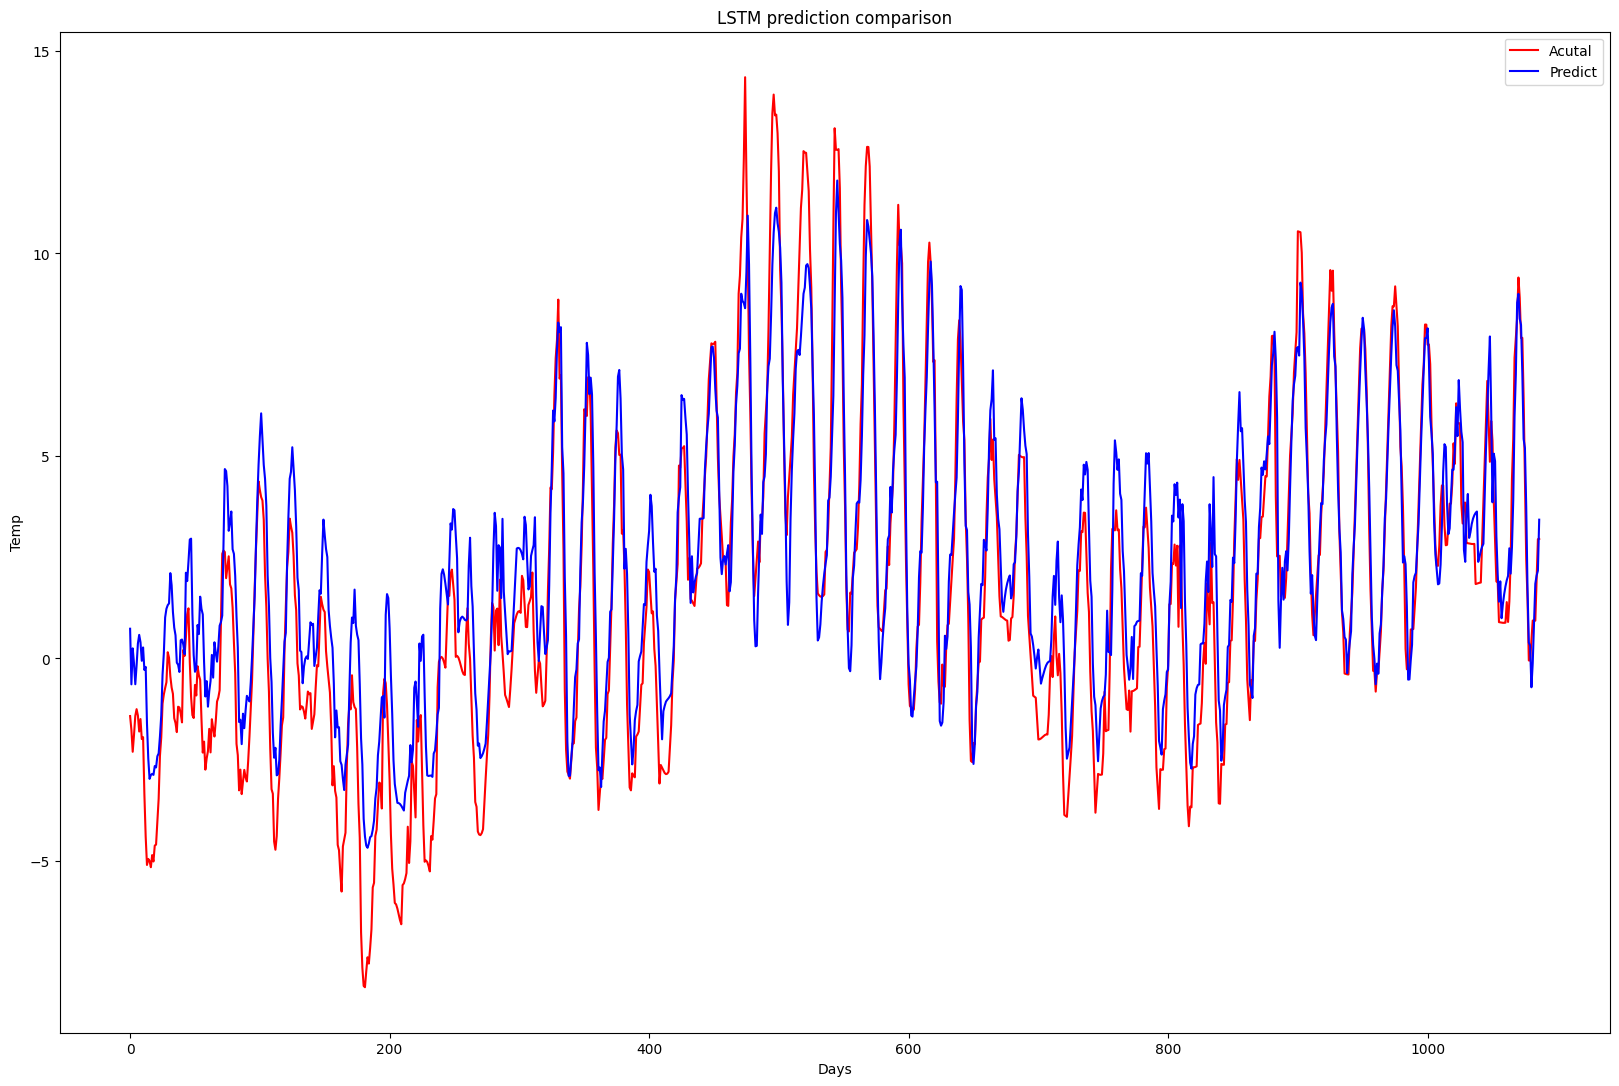

In [47]:
plt.figure(figsize=(20, 13))
plt.plot(y_train_true, color = 'red', label = 'Acutal')
plt.plot(y_train_pred, color = 'blue', label = 'Predict')
plt.title('LSTM prediction comparison')
plt.ylabel('Temp')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset MSE: {MSE} RMSE:{RMSE}')

Training dataset RMSE:1.2663378828627874


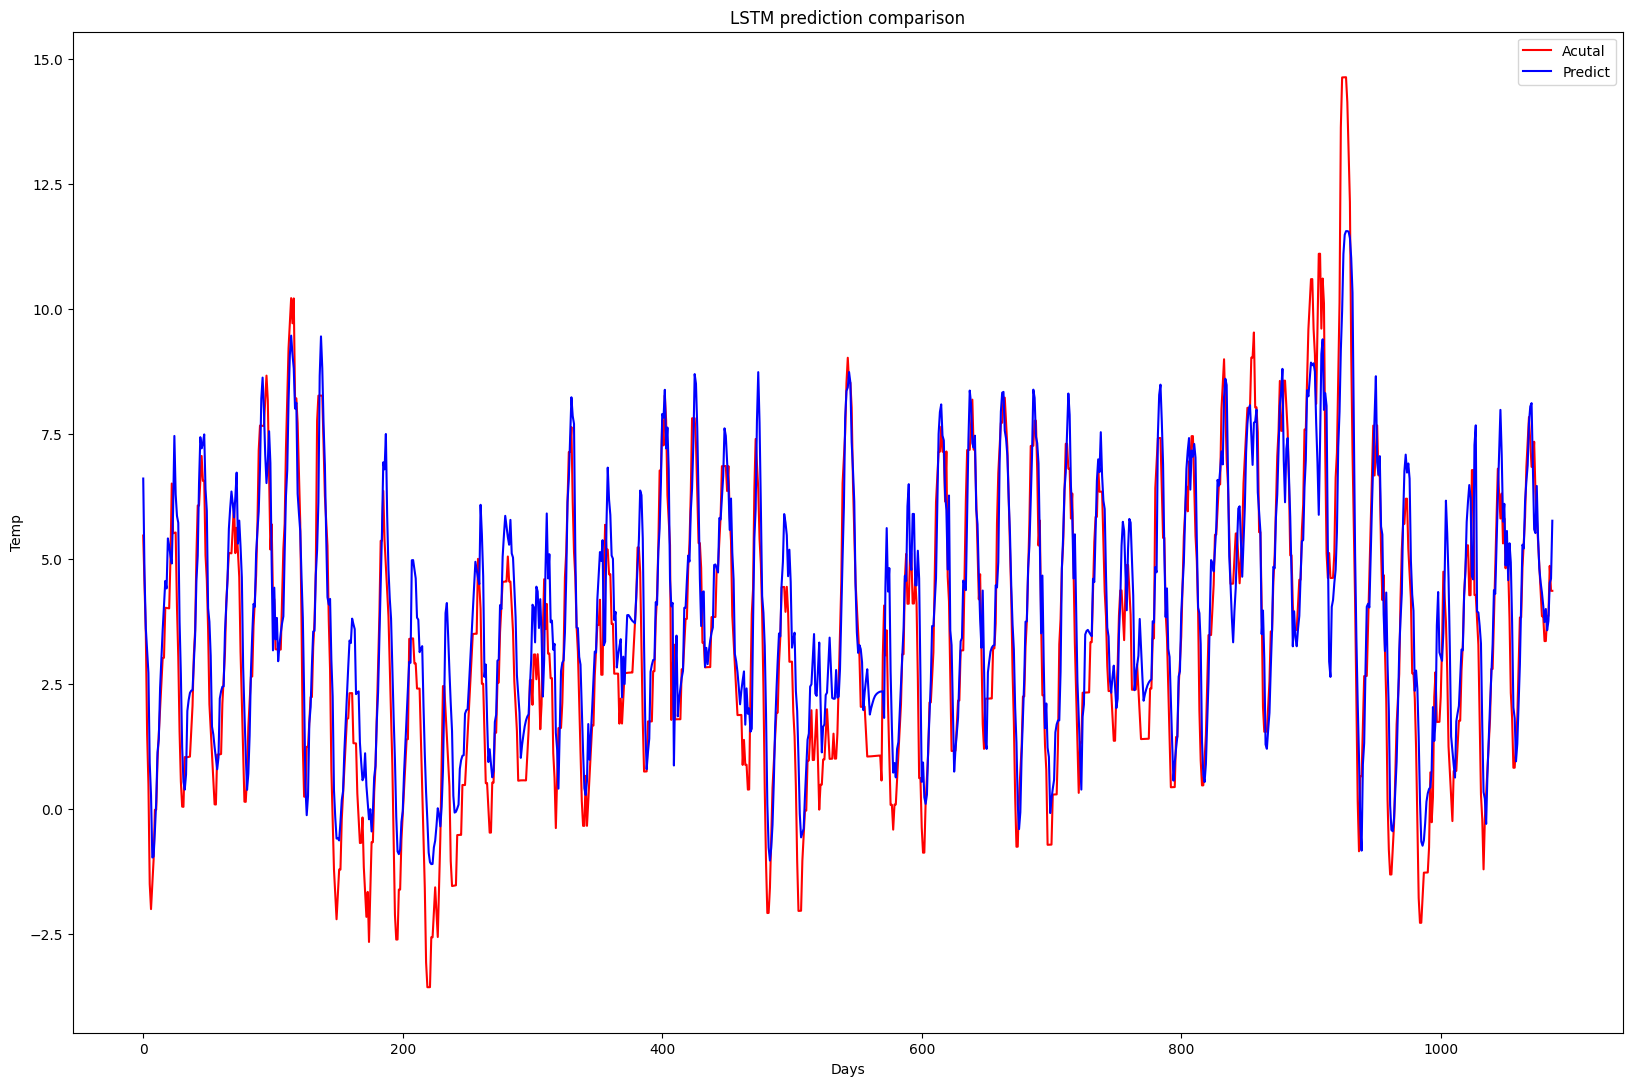

In [48]:
plt.figure(figsize=(20, 13))
plt.plot(y_test_true, color = 'red', label = 'Acutal')
plt.plot(y_test_pred, color = 'blue', label = 'Predict')
plt.title('LSTM prediction comparison')
plt.ylabel('Temp')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

In [49]:
final_result= ARIMA_Result['predicted'][size+window_size:].values + y_test_pred.squeeze(1)

In [50]:
fr = ARIMA_Result[['predicted','raw']][size+window_size:].copy()
fr['final'] = final_result
fr

predicted   raw      final
date                                           
2023-08-15 12:00:00  16.037491  22.5  22.648082
2023-08-15 11:00:00  16.029912  21.5  20.708237
2023-08-15 10:00:00  16.020415  20.5  19.632087
2023-08-15 09:00:00  16.010989  19.5  19.178279
2023-08-15 08:00:00  16.003590  17.5  18.724996
...                        ...   ...        ...
2023-07-01 04:00:00  14.140376  17.5  17.716017
2023-07-01 03:00:00  14.139103  18.0  17.899959
2023-07-01 02:00:00  14.137898  18.0  18.661451
2023-07-01 01:00:00  14.136710  19.0  18.744567
2023-07-01 00:00:00  14.135486  18.5  19.902225

[1087 rows x 3 columns]

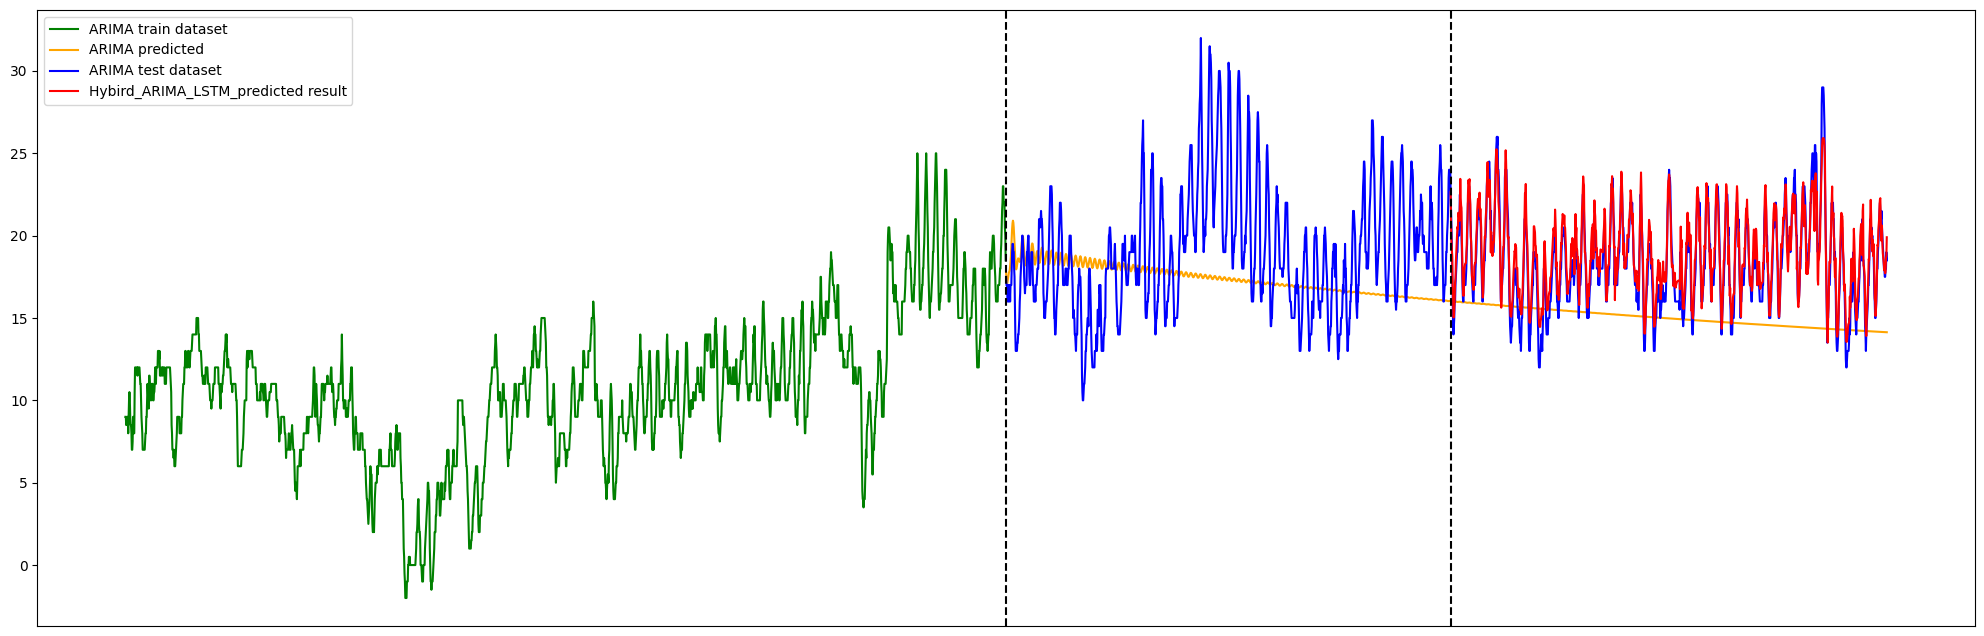

In [51]:
plt.figure(figsize=(25,8))
plt.plot(train_data['temp'], label ='ARIMA train dataset', color='green')
plt.plot(ARIMA_Result['predicted'], label ='ARIMA predicted', color='orange')
plt.plot(ARIMA_Result['raw'], label = "ARIMA test dataset", color ='blue')
plt.plot(fr['final'], label = 'Hybird_ARIMA_LSTM_predicted result', color='red')
plt.axvline(x=len(train_data['temp']), c='black', linestyle='--')
plt.axvline(x=len(train_data['temp']) + len(ARIMA_Result['predicted']) - len(frq['final']), c='black', linestyle='--')
plt.gca().set_xticks([])
plt.plot()
plt.legend()
plt.show()

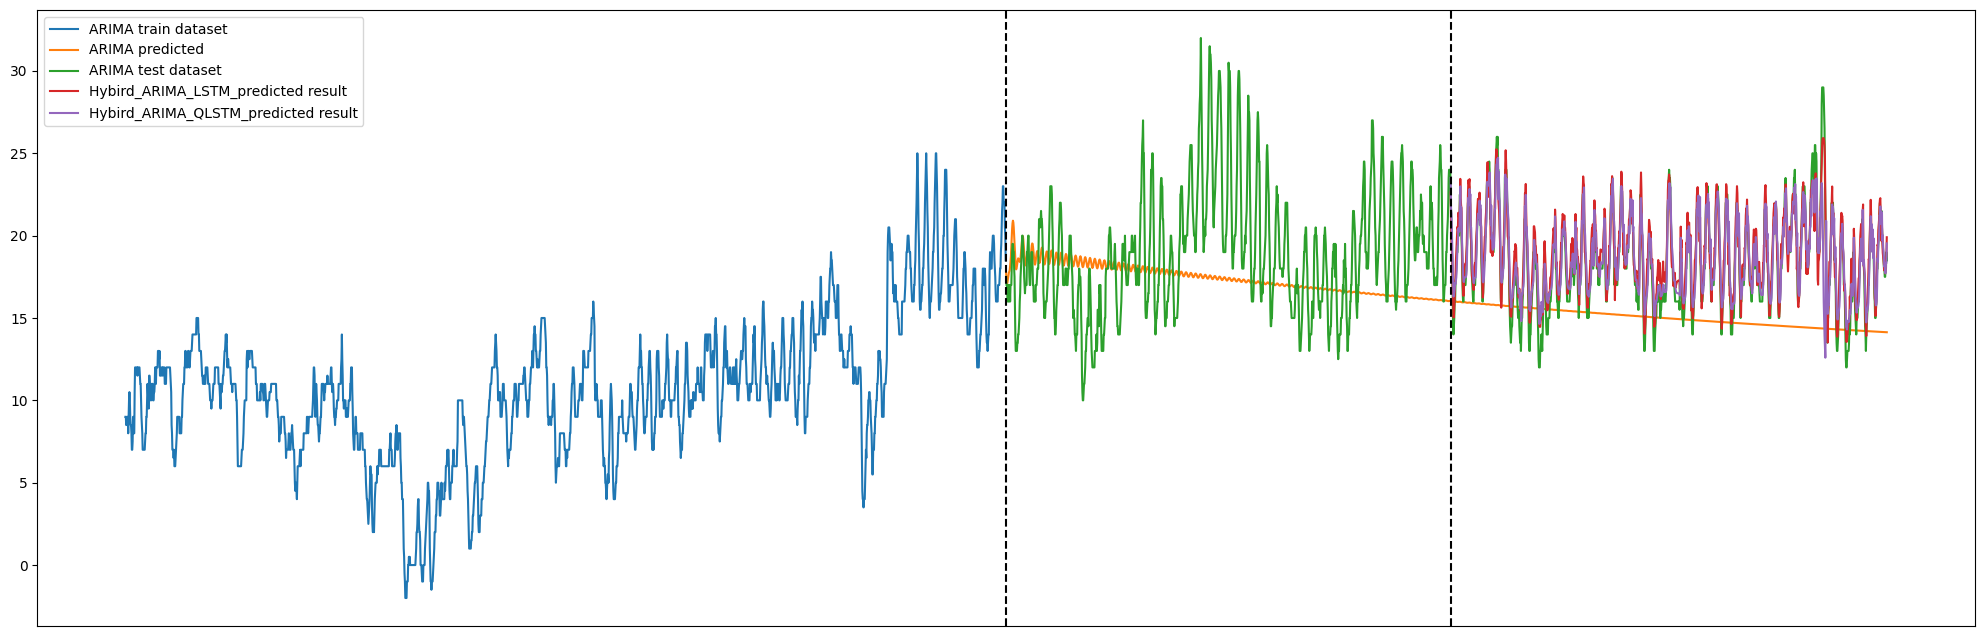

In [52]:
plt.figure(figsize=(25,8))
plt.plot(train_data['temp'], label ='ARIMA train dataset')
plt.plot(ARIMA_Result['predicted'], label ='ARIMA predicted')
plt.plot(ARIMA_Result['raw'], label = "ARIMA test dataset")
plt.plot(fr['final'], label = 'Hybird_ARIMA_LSTM_predicted result')
plt.plot(frq['final'], label = 'Hybird_ARIMA_QLSTM_predicted result')
plt.axvline(x=len(train_data['temp']), c='black', linestyle='--')
plt.axvline(x=len(train_data['temp']) + len(ARIMA_Result['predicted']) - len(frq['final']), c='black', linestyle='--')
plt.gca().set_xticks([])
plt.plot()
plt.legend()
plt.show()

In [53]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

mse = mean_squared_error(final_result,ARIMA_Result['raw'][size+window_size:].values )    
mae = mean_absolute_error(final_result, ARIMA_Result['raw'][size+window_size:].values)
rmse = np.sqrt(mse)

print(f'X_test MSE: {mse}')
print(f'X_test MAE: {mae}')
print(f'X_test RMSE: {rmse}')

X_test MSE: 1.1640206990041784
X_test MAE: 0.8839855532478011
X_test RMSE: 1.078897909444716


In [54]:
torch.save(modelQ,'./SavedModels/Weather/London/model/arima_lstm')

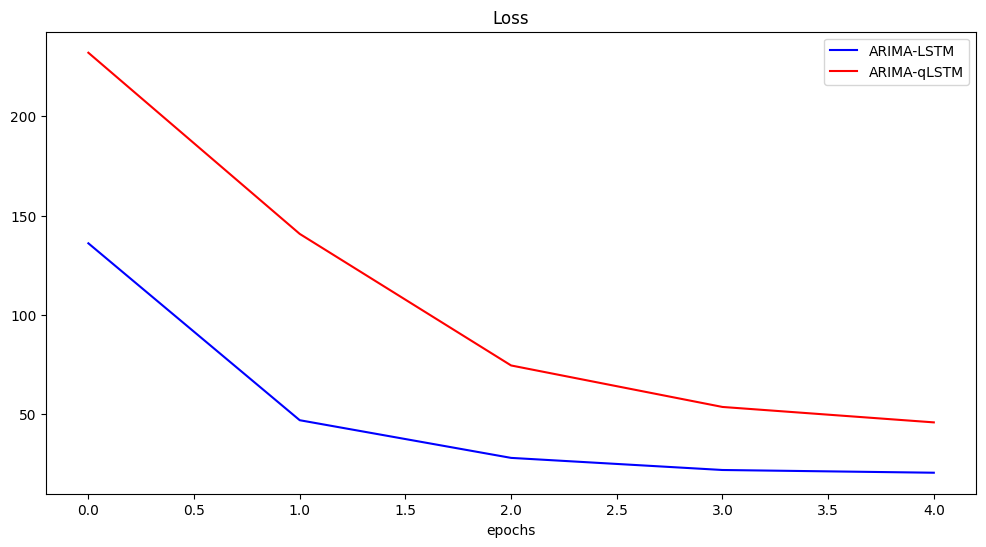

In [55]:
plt.figure(figsize = (12, 6))
plt.plot(histQ, color = 'blue', label = 'ARIMA-LSTM')
plt.plot(histQ1, color='red', label='ARIMA-qLSTM')
plt.title('Loss')
plt.xlabel('epochs')
plt.legend(loc = 'upper right')